In [1]:
import os, sys, re

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["ADAPTIVE_PREFERENCE_ENV"] = "dev"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from umap import UMAP

os.chdir(os.path.expanduser('~/ryandew_adaptive_preference/RA/backend'))
from model.aggregated import PrefOptim

## Silence printing
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

/home/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# SETTINGS - MANUAL ------------------------------------------------------

APP_VERSION = "Binary MPC - MU-Agg"
OUTPUT_FILE = "binmpc_mu-agg"
IS_MPC = True
target_dir = os.path.expanduser("~/ryandew_adaptive_preference/RA/results_analysis/understanding_prefs/binmpc_mu-agg/outputs/")

item_data = pd.read_csv(os.path.expanduser("~/ryandew_adaptive_preference/RA/backend/data/dresses10_urls.csv"))
train_df = pd.read_csv(os.path.expanduser('~/Dropbox/1_proj/urbn/results/binary_mpc_results/analysis-7.3-aggregated-fixed-binary-mpc-None/train_df.csv'))
test_df = pd.read_csv(os.path.expanduser('~/Dropbox/1_proj/urbn/results/binary_mpc_results/analysis-7.3-aggregated-fixed-binary-mpc-None/test_df.csv'))
ind_df = pd.read_csv(os.path.expanduser('~/Dropbox/1_proj/urbn/results/binary_mpc_results/analysis-7.3-aggregated-fixed-binary-mpc-None/individuals.csv'))

# Exclude people who do not pass attention check:
train_df = train_df.loc[ind_df['passed_redisplay'] == 1,:]
test_df = test_df.loc[ind_df['passed_redisplay'] == 1,:]

In [8]:
e_all = item_data.loc[:,"E1":].values

## Helper Function to format data for MPC studies.

def create_pairs(dresses):
    dresses_cols = [col for col in dresses.columns if re.compile(r"E\d+").match(col)]  # Columns like E1, E2, ...
    indexed_dresses = dresses.reset_index(drop=False)  # dresses dataframe with indices ranging from 0 to N
    # Artificial column for catesian product. Pandas version is too low to use how="cross"
    indexed_dresses["_merge_key"] = 0
    merged_all_dresses = pd.merge(indexed_dresses, indexed_dresses, on="_merge_key", how="inner", suffixes=("_1", "_2"))
    merged_filtered_dresses = merged_all_dresses[merged_all_dresses["index_1"] < merged_all_dresses["index_2"]]
    for ix, col in enumerate(dresses_cols, 1):
        merged_filtered_dresses[f"Diff{ix}"] = merged_filtered_dresses[f"{col}_1"] - merged_filtered_dresses[f"{col}_2"]
    return merged_filtered_dresses[
        ["Item_ID_1", "Item_ID_2", "URL_1", "URL_2"] + [f"Diff{ix}" for ix, _ in enumerate(dresses_cols, 1)]
    ].reset_index(drop=True)

pairs_data = create_pairs(item_data)
z_all = pairs_data.loc[:,"Diff1":].values

In [4]:
individuals = list(train_df.index)
z_pred_df = pd.DataFrame(columns=['user_id'] + [str(i) for i in range(z_all.shape[0])])
e_pred_df = pd.DataFrame(columns=['user_id'] + [str(i) for i in range(e_all.shape[0])])
for individual in individuals:
    z_pred_df.loc[len(z_pred_df.index)] = [individual] + [np.nan for i in range(z_all.shape[0])]
    e_pred_df.loc[len(e_pred_df.index)] = [individual] + [np.nan for i in range(e_all.shape[0])]
z_pred_df = z_pred_df.set_index("user_id").sort_index()
e_pred_df = e_pred_df.set_index("user_id").sort_index()

In [5]:
for i in tqdm(individuals):
    if i in test_df.index:
            with HiddenPrints():
                ## All of i's training items and ratings
                items_shown = eval(train_df.loc[i].loc['items_shown'])
                train_X = np.array(z_all[items_shown])
                train_y = np.array(eval(train_df.loc[i].loc['ratings']))

                mirror_X = -train_X
                mirror_y = -train_y
                train_X = np.vstack((train_X, mirror_X))
                train_y = np.concatenate((train_y, mirror_y))

                hypers = eval(train_df.loc[i].hypers)  

                ## Train model
                model = PrefOptim(train_X, train_y)
                z_pred_df.loc[i] = model.compute_utility(z_all)
                e_pred_df.loc[i] = model.compute_utility(e_all)
                

100%|██████████| 118/118 [00:57<00:00,  2.04it/s]


# UMAP Visualizations

In [6]:
umap = UMAP(random_state=0).fit(e_all)
z_umap = umap.fit_transform(e_all)

/home/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [27]:
os.chdir(target_dir)
e_pred_df = pd.read_csv("pred_user_ratings.csv", index_col=0)
z_umap = pd.read_csv("z_umap.csv").values

In [31]:
def depict_umap(preds):
    fig, ax = plt.subplots()
    sc = ax.scatter(x=z_umap[:, 0], y=z_umap[:, 1], c=preds, cmap="inferno", alpha=0.8)
    ax.set_xlabel("UMAP Dim 1")
    ax.set_ylabel("UMAP Dim 2")
    cbar = fig.colorbar(sc)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel("Predicted utility", rotation=270)

    maxid = np.argmax(preds)
    minid = np.argmin(preds)

    return fig, ((maxid, z_umap[maxid, 0], z_umap[maxid, 1]), (minid, z_umap[minid, 0], z_umap[minid, 1]))

In [29]:
high_acc_inds = ind_df.loc[ind_df['fixed_mpc_accuracy'] == 0.9,:].index

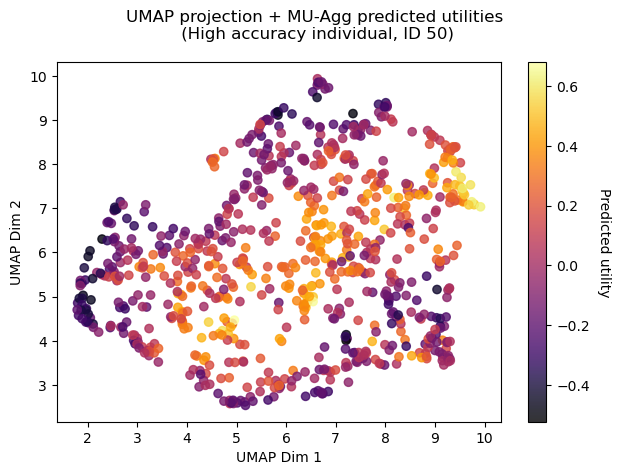

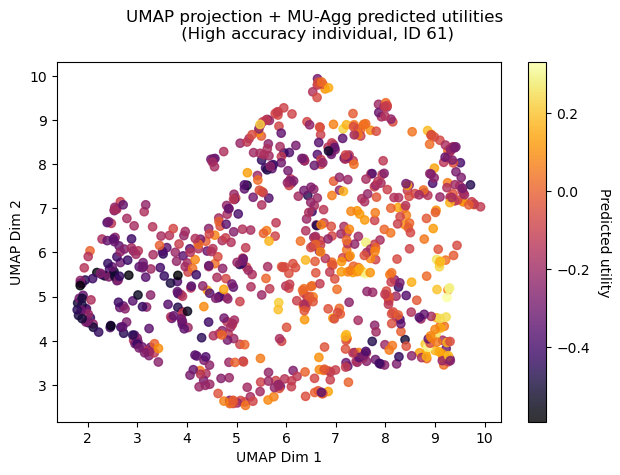

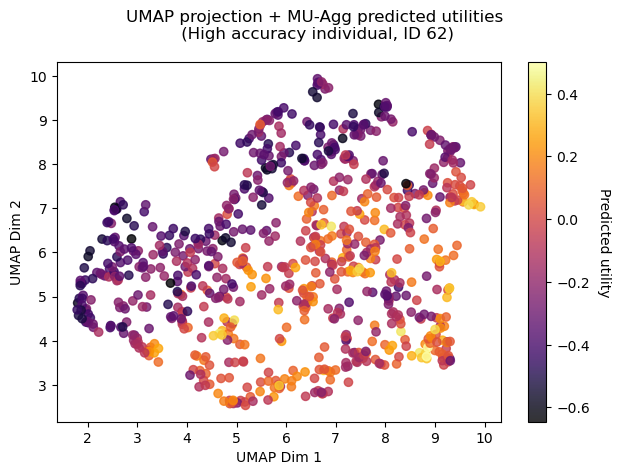

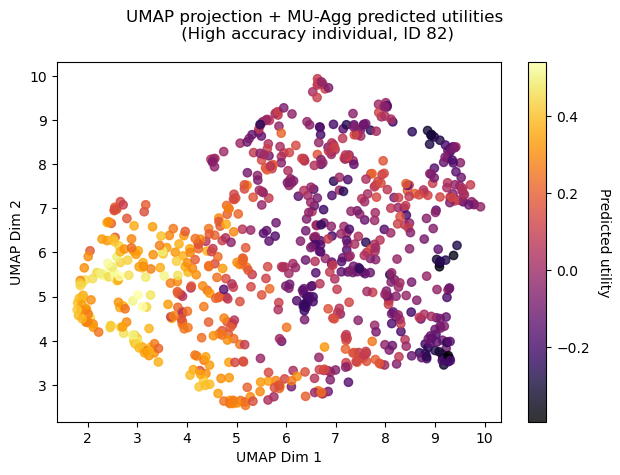

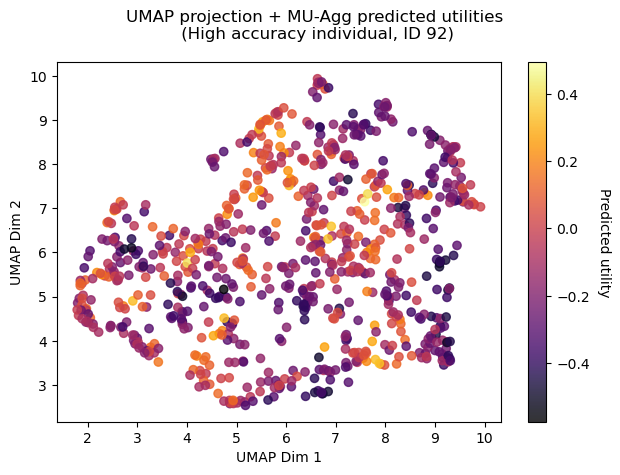

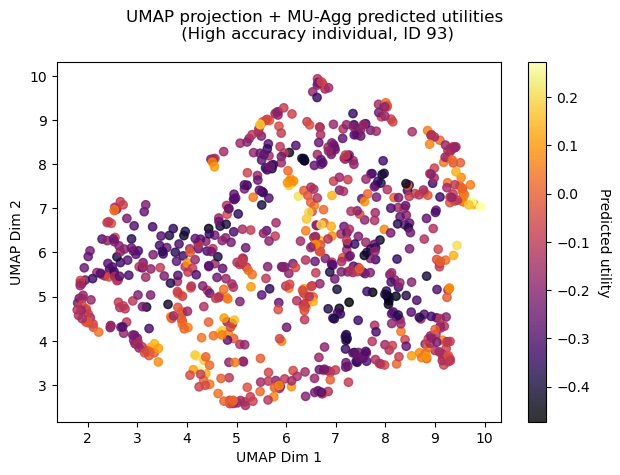

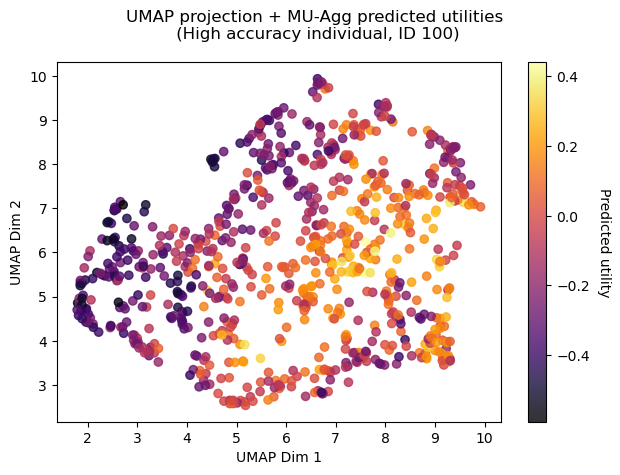

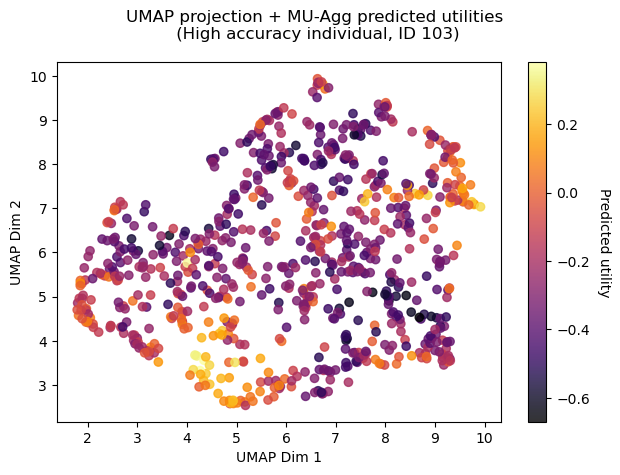

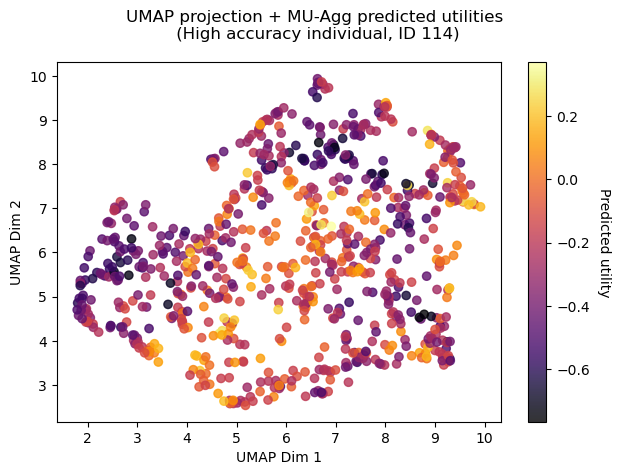

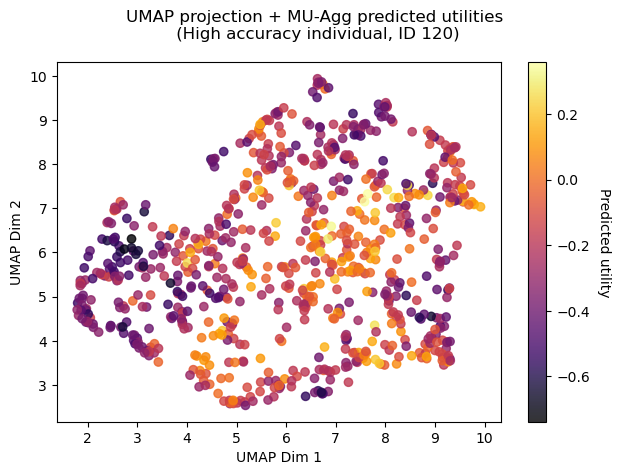

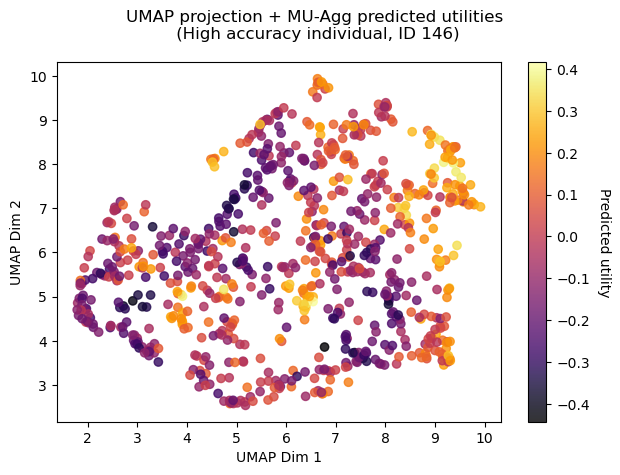

In [32]:
for i in high_acc_inds:
    if i in test_df.index:
        fig, res = depict_umap(preds = e_pred_df.loc[i].values)
        fig.suptitle(
            f"UMAP projection + MU-Agg predicted utilities\n (High accuracy individual, ID {i})"
        )
        fig.tight_layout()
        plt.show()
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        fig.savefig(os.path.join(target_dir, f"{OUTPUT_FILE}_id{i}_umap.pdf"))


In [10]:
## Build example around ID 50
i = 50
pred_i = e_pred_df.loc[i]

In [11]:
item_data

,Item_ID,URL,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10
0,53783866_010,https://s7d2.scene7.com/is/image/nu/53783866_0...,0.243,-0.106,-0.380,0.620,-0.046,0.024,-0.199,0.526,0.033,-0.229
1,54228515_237,https://s7d2.scene7.com/is/image/nu/54228515_2...,0.461,0.475,0.172,0.137,-0.107,0.239,0.532,0.268,-0.148,0.130
2,54685284_000,https://s7d2.scene7.com/is/image/nu/54685284_0...,-0.176,0.193,0.469,0.573,0.325,-0.299,0.081,0.127,0.269,-0.268
3,52190816_024,https://s7d2.scene7.com/is/image/nu/52190816_0...,-0.400,0.493,-0.213,0.218,0.036,-0.237,-0.018,0.596,0.111,0.196
4,55047476_000,https://s7d2.scene7.com/is/image/nu/55047476_0...,-0.112,-0.149,0.285,0.020,0.249,0.362,-0.392,0.576,0.389,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...
809,4130292120004_009,https://s7d2.scene7.com/is/image/nu/4130292120...,-0.044,0.247,-0.041,0.012,0.073,-0.070,0.367,0.108,-0.807,0.325
810,54724703_011,https://s7d2.scene7.com/is/image/nu/54724703_0...,0.231,-0.420,0.158,0.171,-0.380,0.220,0.278,-0.115,0.648,0.019
811,54681093_009,https://s7d2.scene7.com/is/image/nu/54681093_0...,0.214,-0.370,0.227,0.506,0.426,-0.117,0.464,0.272,0.150,-0.060
812,52117819_040,https://s7d2.scene7.com/is/image/nu/52117819_0...,-0.409,0.184,-0.393,-0.192,-0.082,-0.331,-0.317,0.426,0.441,0.027


In [12]:
left_side_items = np.argsort(pred_i)[[4,6]]
right_side_items = np.argsort(pred_i)[::-1][[2,3]]
example_urls = item_data.loc[np.concatenate((left_side_items, right_side_items)), "URL"]
pd.set_option('display.max_colwidth', None)
example_urls

546    https://s7d2.scene7.com/is/image/nu/4130348690087_038_b?$pdp-regular$
637         https://s7d2.scene7.com/is/image/nu/54457031_065_b?$pdp-regular$
376         https://s7d2.scene7.com/is/image/nu/52103314_092_b?$pdp-regular$
513         https://s7d2.scene7.com/is/image/nu/54169222_000_b?$pdp-regular$
Name: URL, dtype: object

# Clustering


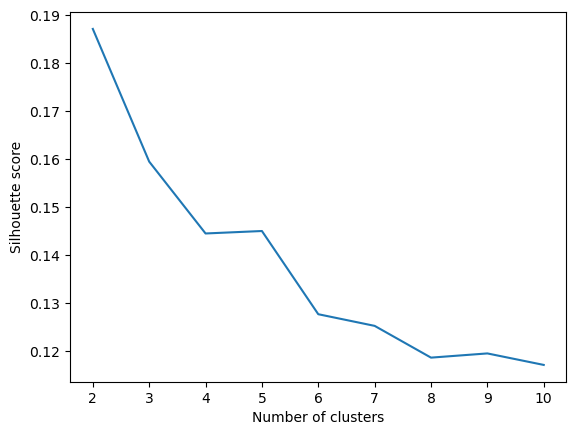

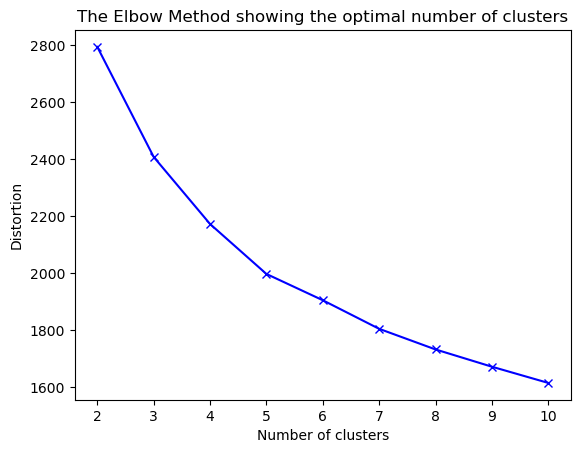

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# create a list to store the silhouette scores for each number of clusters
silhouette_scores = []

# set the range of number of clusters to try
k_range = range(2, 11)

# loop through each number of clusters and calculate the silhouette score
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(e_pred_df)
    silhouette_scores.append(silhouette_score(e_pred_df, cluster_labels))

# plot the silhouette scores for each number of clusters
plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# use the elbow method to determine the optimal number of clusters
distortions = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(e_pred_df)
    distortions.append(kmeans.inertia_)

plt.plot(k_range, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()


In [14]:
# set the number of clusters
n_clusters = 6

# create the k-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# fit the model to the data
kmeans.fit(e_pred_df)

# get the cluster labels
cluster_assignments = kmeans.labels_
cluster_means = e_pred_df.groupby(cluster_assignments).mean()

In [35]:
cluster_means = pd.read_csv('cluster_means.csv', index_col=0)
cluster_assignments = pd.read_csv('cluster_assignments.csv').values
n_clusters = cluster_means.shape[0]

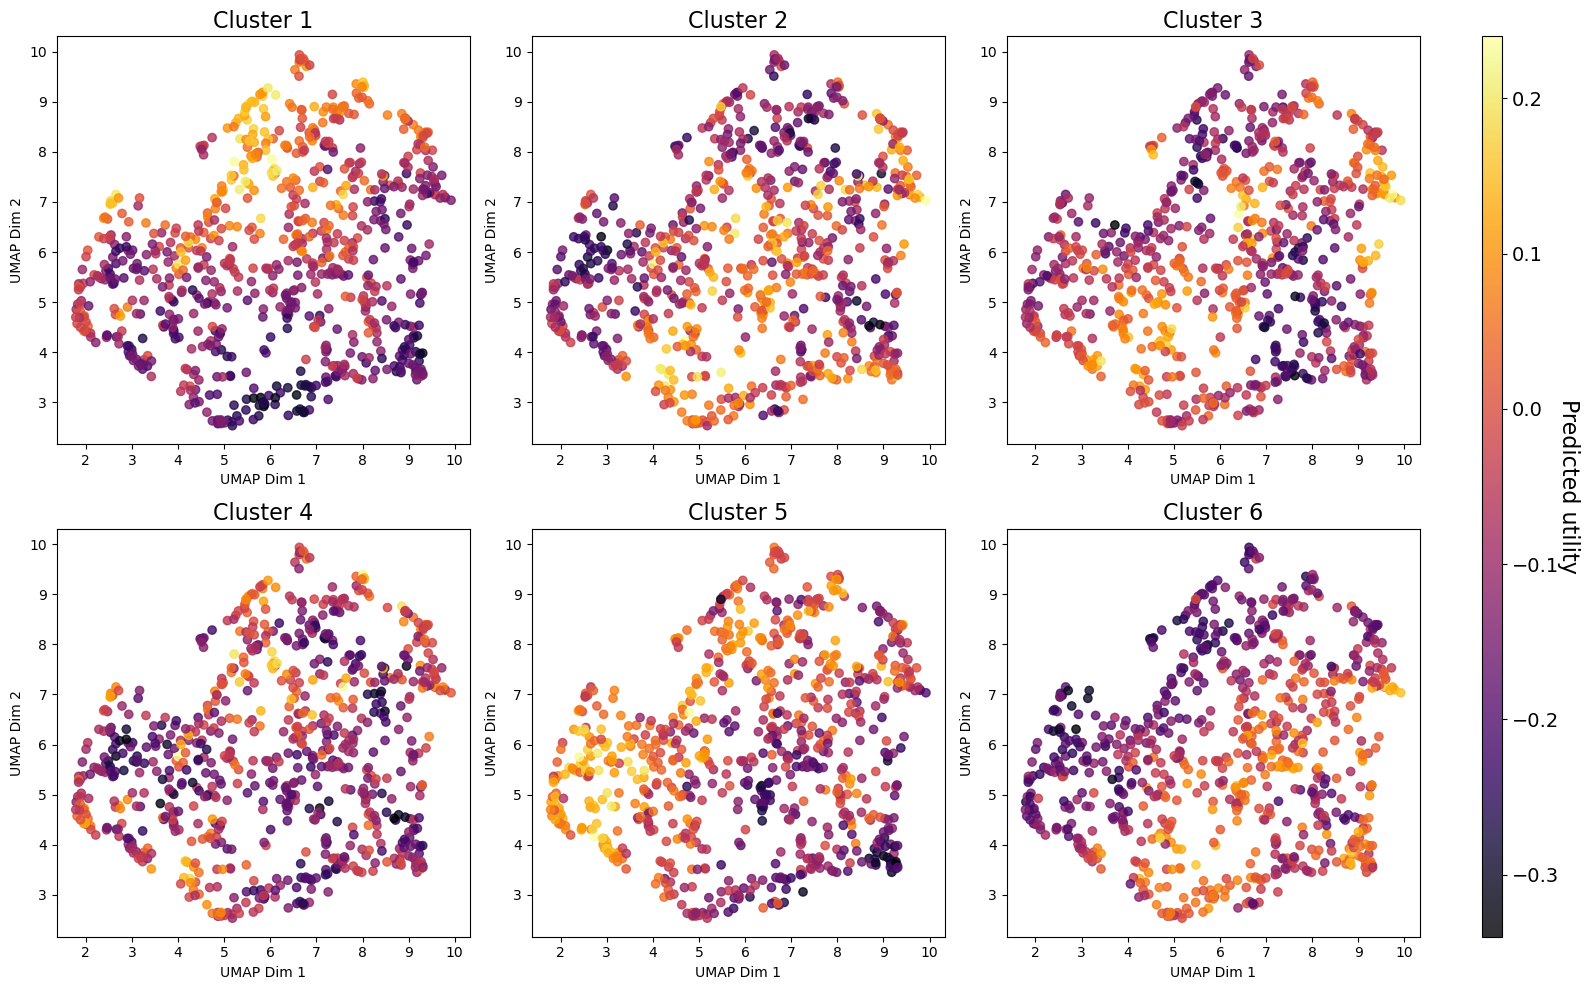

In [41]:
import matplotlib.gridspec as gridspec

def depict_umap_ax(preds, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    
    sc = ax.scatter(x=z_umap[:, 0], y=z_umap[:, 1], c=preds, cmap="inferno", alpha=0.8)
    ax.set_xlabel("UMAP Dim 1")
    ax.set_ylabel("UMAP Dim 2")
    
    maxid = np.argmax(preds)
    minid = np.argmin(preds)

    return fig, sc, ((maxid, z_umap[maxid, 0], z_umap[maxid, 1]), (minid, z_umap[minid, 0], z_umap[minid, 1]))

# Create the GridSpec layout
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05])

fig = plt.figure(figsize=(16, 10))

scatters = []

for i in range(n_clusters):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col])
    _, sc, res = depict_umap_ax(preds=cluster_means.iloc[i].values, ax=ax)
    scatters.append(sc)
    ax.set_title(f"Cluster {i+1}", fontsize=16)

# Add the colorbar in the fourth column
cbar_ax = fig.add_subplot(gs[:, 3])
cbar = fig.colorbar(scatters[0], cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Predicted utility", rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.tight_layout()

# Save the figure
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
fig.savefig(os.path.join(target_dir, f"{OUTPUT_FILE}_cluster_umap.pdf"))
fig.savefig(os.path.join(target_dir, f"{OUTPUT_FILE}_cluster_umap.png"))


Saving relevant stuff:

In [18]:
# e_pred_df.to_csv("pred_user_ratings.csv")
# z_umap_df = pd.DataFrame(z_umap, columns=['UMAP Dim 1', 'UMAP Dim 2'])
# z_umap_df.to_csv('z_umap.csv', index=False)
# cluster_means.to_csv('cluster_means.csv')
# cluster_assignments_df = pd.DataFrame(cluster_assignments, columns=['cluster'])
# cluster_assignments_df.to_csv('cluster_assignments.csv', index=False)